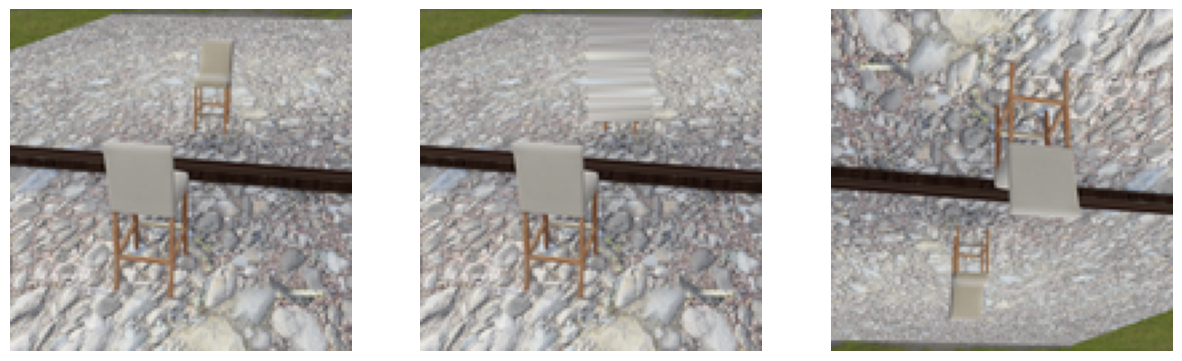

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 读取图像
image_path = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors_train/left/00005.png"
image1 = Image.open(image_path).convert("RGB")
image1_np = np.array(image1)

# 计算插值区域
h, w, c = image1_np.shape
upper_half = image1_np[:int(h//3)].copy()  # 取上半部分
x1, x2 = w//2, 2*w//3  # 插值范围

# 线性插值：用两边的像素填充中间区域
for x in range(x1, x2):
    alpha = (x - x1) / (x2 - x1)
    upper_half[:, x] = (1 - alpha) * upper_half[:, x1 - 1] + alpha * upper_half[:, x2]

# 合成 image2
image2_np = image1_np.copy()
image2_np[:int(h//3)] = upper_half

# 旋转得到 image3
image3 = image1.rotate(180)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image1)
# axes[0].set_title("Image 1 (Original)")
axes[0].axis("off")

axes[1].imshow(image2_np)
# axes[1].set_title("Image 2 (Interpolated Upper Part)")
axes[1].axis("off")

axes[2].imshow(image3)
# axes[2].set_title("Image 3 (Rotated)")
axes[2].axis("off")
plt.savefig("/cpfs04/user/hanyujin/rule-gen/output.png")
plt.show()


In [30]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import clip
from torchvision import transforms
from tqdm import tqdm

# 选择设备
device = "cuda" if torch.cuda.is_available() else "cpu"

# 加载 CLIP 模型
model, preprocess = clip.load("ViT-L/14", device=device)

# 图像文件夹路径
image_dir = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left"

# 获取所有 PNG 文件
image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]

# 如果总数大于1000，则随机采样1000张
sample_size = min(1000, len(image_files))
image_files = random.sample(image_files, sample_size)

# 存储 CLIP Score
remove_reflection_scores = []
rotation_scores = []

# 遍历采样的图片
for image_name in tqdm(image_files, desc="Processing Images"):
    image_path = os.path.join(image_dir, image_name)

    # 读取原始图像
    image1 = Image.open(image_path).convert("RGB")
    image1_np = np.array(image1)

    # 计算插值区域（去反射）
    h, w, c = image1_np.shape
    upper_half = image1_np[:int(h//3)].copy()  # 取上半部分
    x1, x2 = w//3, 2*w//3  # 插值范围

    # 线性插值填充
    for x in range(x1, x2):
        alpha = (x - x1) / (x2 - x1)
        upper_half[:, x] = (1 - alpha) * upper_half[:, x1 - 1] + alpha * upper_half[:, x2]

    # 合成 image2（去反射）
    image2_np = image1_np.copy()
    image2_np[:int(h//3)] = upper_half
    image2 = Image.fromarray(image2_np)

    # 旋转得到 image3
    image3 = image1.rotate(180)

    # 预处理图像
    def preprocess_image(image):
        return preprocess(image).unsqueeze(0).to(device)

    image1_tensor = preprocess_image(image1)
    image2_tensor = preprocess_image(image2)
    image3_tensor = preprocess_image(image3)

    # 计算特征
    with torch.no_grad():
        image1_feat = model.encode_image(image1_tensor)
        image2_feat = model.encode_image(image2_tensor)
        image3_feat = model.encode_image(image3_tensor)

    # 归一化
    image1_feat /= image1_feat.norm(dim=-1, keepdim=True)
    image2_feat /= image2_feat.norm(dim=-1, keepdim=True)
    image3_feat /= image3_feat.norm(dim=-1, keepdim=True)

    # 计算余弦相似度（CLIP Score）
    clip_score_1_2 = (image1_feat @ image2_feat.T).item()
    clip_score_1_3 = (image1_feat @ image3_feat.T).item()

    # 存入列表
    remove_reflection_scores.append(clip_score_1_2)
    rotation_scores.append(clip_score_1_3)


100%|███████████████████████████████████████| 890M/890M [00:37<00:00, 24.8MiB/s]
Processing Images: 100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]


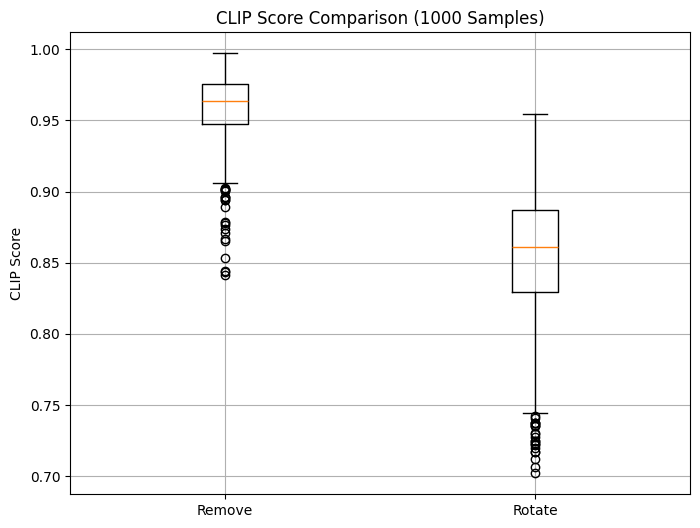

In [31]:
plt.figure(figsize=(8, 6))
plt.boxplot([remove_reflection_scores, rotation_scores], labels=["Remove", "Rotate"])
plt.ylabel("CLIP Score")
plt.title("CLIP Score Comparison (1000 Samples)")
plt.grid(True)
plt.show()

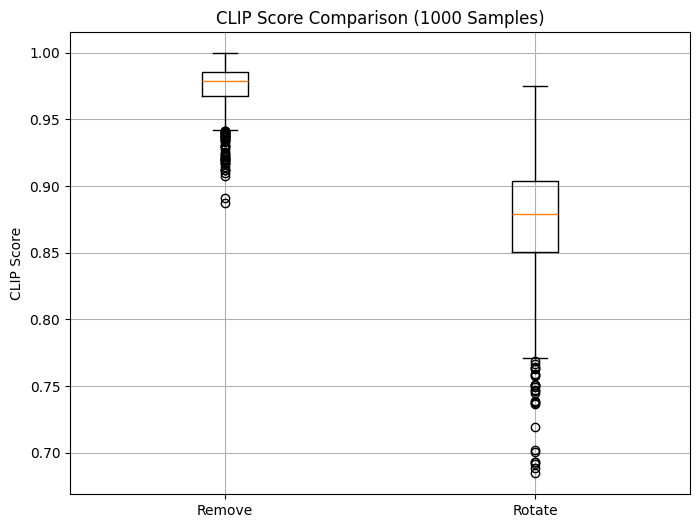

In [13]:
# ViT-16
plt.figure(figsize=(8, 6))
plt.boxplot([remove_reflection_scores, rotation_scores], labels=["Remove", "Rotate"])
plt.ylabel("CLIP Score")
plt.title("CLIP Score Comparison (1000 Samples)")
plt.grid(True)
plt.show()
